## Programming Exercise 4: Neural Networks Learning

#### Setup

In [1]:
import numpy as np
from scipy.io import loadmat
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from IPython.display import Image

data = loadmat('ex4data1.mat')
weights = loadmat('ex4weights.mat')

In [2]:
# Padded with the ones at the beggining
X, y = np.c_[np.ones((data['X'].shape[0],1)), data['X']], data['y'] 
# Showing that the weights contains theta1 and theta2
weights.keys()

['Theta2', '__version__', '__header__', 'Theta1', '__globals__']

#### Displaying the Data

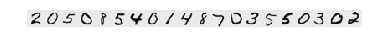

In [3]:
rand_indices = np.random.choice(X.shape[0], 20)
sel1 = X[rand_indices[0:20], 1:].reshape(-1,20).T

plt.imshow(sel1, cmap='gray_r')
plt.axis('off')
plt.show()

#### Model Representation
Taken from the assignment's documentation:

![Model](img/Neural_Network_Model.png)

#### Feedforward and cost function

In [4]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

def sigmoid_gradient(x):
    return sigmoid(x) * (1 - sigmoid(x))

def nn_cost_function(nn_params, num_labels, X, y, reg):
    
    # Extracting the Thetas
    theta1 = nn_params['Theta1']
    theta2 = nn_params['Theta2']
    
    # Setuping some variables
    m = X.shape[0]
    J = 0
    theta1_grad = np.zeros((theta1.shape))
    theta2_grad = np.zeros((theta2.shape))
    
    # Regularization Function for the Cost
    regfunc = float(reg) / (2. * m) * (np.square(theta1).sum() + np.square(theta2).sum())
    
    # FF neural network
    ## Since X is already padded with 1 we don't need to add ones
    a1 = X 
    ## Calculating the Hidden Layer
    a2 = sigmoid(X.dot(theta1.T))
    ## Then adding 1s
    a2 = np.c_[np.ones((a2.shape[0],1)), a2]
    ## Calculating the hypothesis
    h_thx = sigmoid(a2.dot(theta2.T))
    
    # Calculating the Cost Function
    for label in xrange(num_labels):
        y_label = y == label + 1 # since python indexing starts from 0
        h = h_thx[:,label].reshape(-1,1)
        J_label = - 1. / m * (np.log(h).T.dot(y_label) + np.log(1 - h).T.dot(1 - y_label))
        J = J + J_label
        
    # Calculating the Gradients
#     for i in xrange(m):
#         for label in xrange(num_labels):
#             yk = y
    
    
    return J + regfunc


##### Testing

In [6]:
# Cost Function with Lambda = 0
cost_0 = nn_cost_function(weights, 10, X, y, 0)
print "Should be about 0.287629: %f" % (cost_0)
# Cost Function with Lambda = 1; Should be equal to 0.383770
cost_1 = nn_cost_function(weights, 10, X, y, 1)
print "Should be about 0.383770: %f" % (cost_1)

# Testing Sigmoid Gradient
tst = np.array([-1, -0.5, 0, 0.5, 1])
g = sigmoid_gradient(tst)
print "Sigmoid Gradient. The 3rd value should be 0.25: " + str(g)


Should be about 0.287629: 0.287629
Should be about 0.383770: 0.384488
Sigmoid Gradient. The 3rd value should be 0.25: [ 0.19661193  0.23500371  0.25        0.23500371  0.19661193]


#### Random Initialization
Selecting values uniformly in the range [-0.12,0.12]

In [33]:
def rand_init_weights(l_in, l_out, num_labels):
    w_hidden_layer = np.random.uniform(0,1,(l_out, l_in + 1)) * 2 * 0.12 - 0.12
    w_output = np.random.uniform(0,1,(num_labels, w_hidden_layer.shape[0] + 1)) * 2 * 0.12 - 0.12
    
    # Combining to be consistent with the input of the nn cost function
    return {
        'Theta1':w_hidden_layer,
        'Theta2':w_output
    }

##### Initial Thetas

In [36]:
initial_weights = rand_init_weights(400, 25, 10)

(25, 401)